In [1]:
from phi.torch.flow import *
from tqdm.notebook import trange

In [2]:
def simulate_hit(pos, height, vel, angle, gravity=1.):
    vel_x, vel_y = math.cos(angle) * vel, math.sin(angle) * vel
    height = math.maximum(height, .01)
    hit_time = (vel_y + math.sqrt(vel_y**2 + 2 * gravity * height)) / gravity
    return pos + vel_x * hit_time, hit_time, height, vel_x, vel_y

def sample_trajectory(pos, height, vel, angle, gravity=1., steps=spatial(time=100)):
    _, hit_time, height, vel_x, vel_y = simulate_hit(pos, height, vel, angle, gravity)
    t = math.linspace(0, hit_time, steps)
    return vec(x=pos + vel_x * t, y=height + vel_y * t - gravity / 2 * t ** 2)

In [3]:
def generate_data(shape):
    pos = math.random_normal(shape)
    height = math.random_uniform(shape) + .5
    vel = math.random_uniform(shape)
    angle = math.random_uniform(shape) * PI/2
    return math.stack(dict(pos=pos, height=height, vel=vel, angle=angle), channel('vector'))

x_train = generate_data(batch(example=1000))
x_test = generate_data(batch(example=1000))
y_train = simulate_hit(*x_train.vector)[0]
y_test = simulate_hit(*x_test.vector)[0]

In [4]:
math.seed(0)
net_sup = dense_net(1, 4, [32, 64, 32])
math.seed(0)
net_dp = dense_net(1, 4, [32, 64, 32])
math.assert_close(get_parameters(net_sup)['linear1.weight'], get_parameters(net_dp)['linear1.weight'])

In [5]:
opt_sup = adam(net_sup)

def supervised_loss(x, y, net=net_sup):
    prediction = math.native_call(net, y)
    return math.l2_loss(prediction - x), prediction

print(f"Initial supervised loss (test set): {supervised_loss(x_test, y_test)}")

sup_pred_trj = []
for i in range(200):
    update_weights(net_sup, opt_sup, supervised_loss, x_train, y_train)
    sup_pred_trj.append(math.native_call(net_sup, y_test))

print(f"Final supervised loss (test set): {supervised_loss(x_test, y_test)}")

Initial supervised loss (test set): ((exampleᵇ=1000) 1.583 ± 0.840 (2e-01...9e+00), (exampleᵇ=1000, vectorᶜ=4) 0.007 ± 0.026 (-9e-02...2e-01))
Final supervised loss (test set): ((exampleᵇ=1000) 0.269 ± 0.180 (6e-03...1e+00), (exampleᵇ=1000, vectorᶜ=4) 0.576 ± 0.592 (-3e+00...3e+00))


In [6]:
opt_dp = adam(net_dp)

def physics_loss(y, net=net_dp):
    prediction = math.native_call(net, y)
    y_sim = simulate_hit(*prediction.vector)[0]
    return math.l2_loss(y_sim - y)

print(f"Initial supervised loss (test set): {supervised_loss(x_test, y_test, net=net_dp)}")

dp_pred_trj = []
for i in range(200):
    update_weights(net_dp, opt_dp, physics_loss, y_train)
    dp_pred_trj.append(math.native_call(net_dp, y_test))

print(f"Final supervised loss (test set): {supervised_loss(x_test, y_test, net=net_dp)}")

Initial supervised loss (test set): ((exampleᵇ=1000) 1.583 ± 0.840 (2e-01...9e+00), (exampleᵇ=1000, vectorᶜ=4) 0.007 ± 0.026 (-9e-02...2e-01))
Final supervised loss (test set): ((exampleᵇ=1000) 1.117 ± 0.672 (4e-02...4e+00), (exampleᵇ=1000, vectorᶜ=4) 0.201 ± 0.469 (-2e+00...2e+00))


In [7]:
print(f"Supervised network (test set): {physics_loss(y_test, net=net_sup)}")
print(f"Diff.Phys. network (test set): {physics_loss(y_test, net=net_dp)}")

Supervised network (test set): (exampleᵇ=1000) 3.60e-03 ± 8.9e-04 (1e-03...6e-03)
Diff.Phys. network (test set): (exampleᵇ=1000) 2.52e-05 ± 6.5e-05 (4e-12...1e-03)


In [8]:
opt_trjs = stack({
    "Ground truth": x_test,
    "Supervised": stack(sup_pred_trj, batch('iter')),
    "Diff.Phys.": stack(dp_pred_trj, batch('iter'))
}, channel('type'))
plot(sample_trajectory(*opt_trjs.example[:4].iter[::4].vector), animate='iter')

<Figure size 1200x500 with 16 Axes>

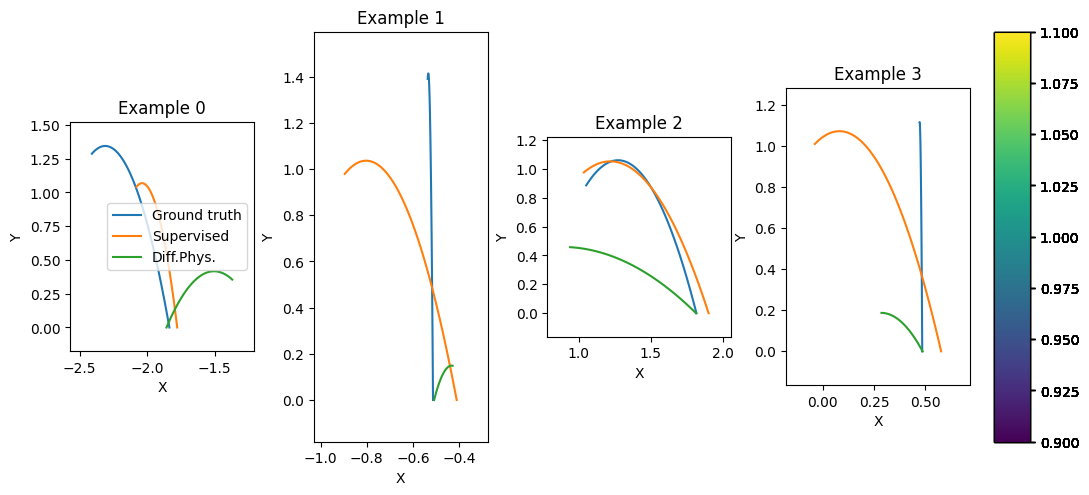

In [9]:
plot(sample_trajectory(*opt_trjs.example[:4].iter[-1].vector))